<a href="https://colab.research.google.com/github/shekharkhandelwal1983/DLforDataArchitects/blob/main/notebooks/chapter9/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
batch_size = 64

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 170498071/170498071 [00:13<00:00, 12321370.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, channels=3):
        super().__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, 512, 4, 1, 0), # 4x4
            self._block(512, 256, 4, 2, 1), # 8x8
            self._block(256, 128, 4, 2, 1), # 16x16
            self._block(128, 64, 4, 2, 1), # 32x32
            # Output: N x channels x 64 x 64
            nn.ConvTranspose2d(64, channels, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.gen(x.view(len(x), self.z_dim, 1, 1))


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super().__init__()

        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            self._block(channels, 64, 4, 2, 1), # 32x32
            self._block(64, 128, 4, 2, 1), # 16x16
            self._block(128, 256, 4, 2, 1), # 8x8
            self._block(256, 512, 4, 2, 1), # 4x4
            # Output: N x 1
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.disc(x).view(-1)


In [6]:
z_dim = 128
lr = 0.0002
gen = Generator(z_dim).to(device)
gen_opt = optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCELoss()


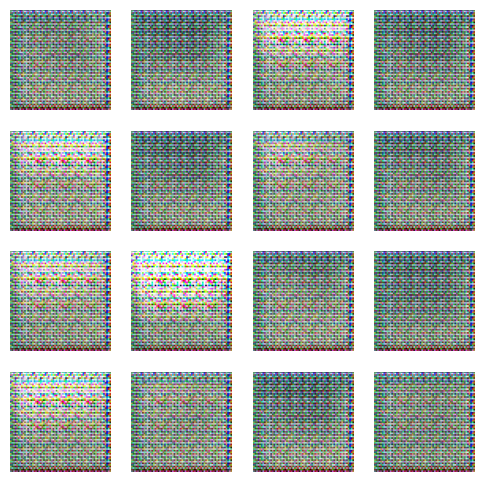

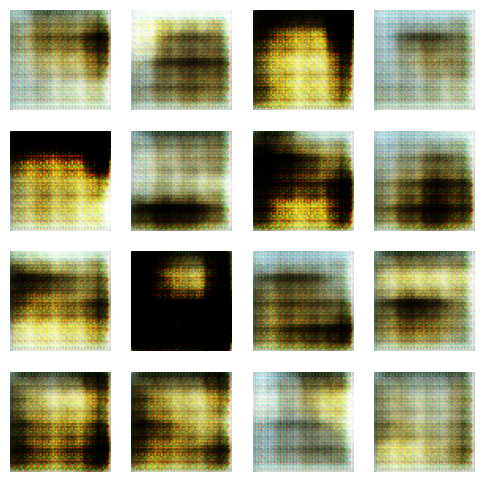

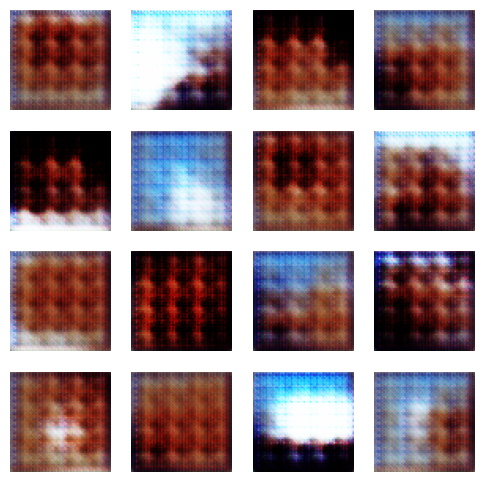

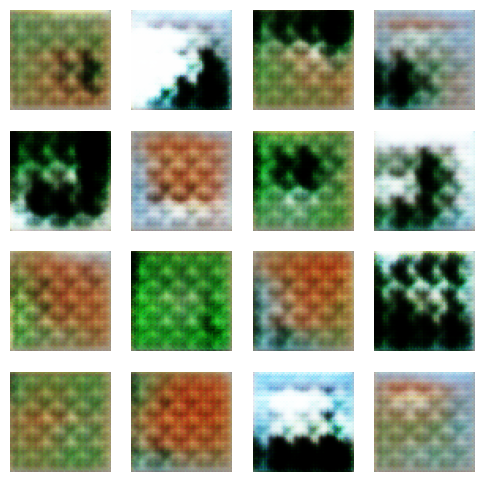

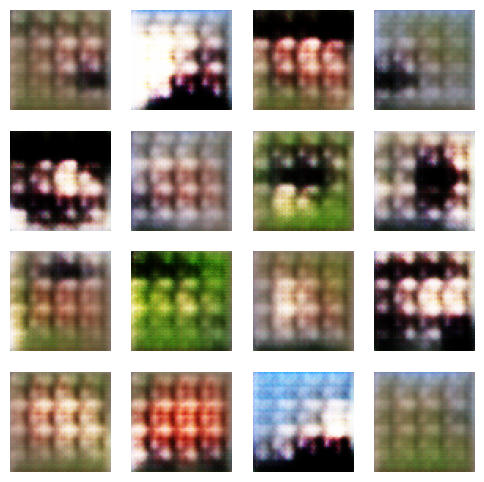

In [7]:
n_epochs = 5
sample_size = 64
fixed_noise = torch.randn(sample_size, z_dim, device=device)

for epoch in range(n_epochs):
    for real, _ in dataloader:
        real = real.to(device)
        noise = torch.randn(real.shape[0], z_dim, device=device)
        fake = gen(noise)

        # Train Discriminator
        disc_opt.zero_grad()
        disc_loss = criterion(disc(real), torch.ones(real.size(0), device=device)) + criterion(disc(fake.detach()), torch.zeros(real.size(0), device=device))
        disc_loss.backward()
        disc_opt.step()

        # Train Generator
        gen_opt.zero_grad()
        gen_loss = criterion(disc(fake), torch.ones(real.size(0), device=device))
        gen_loss.backward()
        gen_opt.step()

    # Output Images
    with torch.no_grad():
        samples = gen(fixed_noise)
        samples = (samples + 1) / 2
        samples = samples.cpu().permute(0, 2, 3, 1).numpy()
        plt.figure(figsize=(6, 6))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(samples[i])
            plt.axis('off')
        plt.show()
